# Resource-Constrained Project Scheduling with Time-Offs

This notebook addresses RCPSP variants where resources have individual availability calendars. It explores five problems that differ in how tasks handle interruptions and resource reassignments. Each resource unit of each resource type has its own availability calendar (available/unavailable periods). Preemption is possible either by changing resource units of the same resource type during execution (if migration is allowed) or by pausing the task execution according to its calendar (and after the pause continuing on the same resource unit).

1. **[Non-Preemptive | No Migration](#1-non-preemptive--no-migration)**: Tasks execute continuously without interruption, resources must be available throughout entire task duration
2. **[Preemptive (No Delays) | Migration](#2-preemptive-no-delays--migration)**: Tasks pause and immediately switch to available alternative resources
3. **[Preemptive (With Delays) | No Migration](#3-preemptive-with-delays--no-migration)**: Tasks pause when resources are unavailable, resume later on the same resources; resources remain blocked during pauses
4. **[Preemptive (With Delays) | Migration](#4-preemptive-with-delays--migration)**: Combines pausing with the ability to switch resource units
5. **[Multi-Resource Heterogeneous Policy](#5-multi-resource-heterogeneous-policy)**: Different resource types follow different policies. workers allow migration while machines do not


### Imports & Parsing

In [42]:
import docplex.cp.utils_visu as visu
import matplotlib as plt
from itertools import combinations, product
from docplex.cp.model import CpoStepFunction

In [43]:
def next_line(f):
    """Read next non-empty, non-comment line."""
    while True:
        raw = f.readline()
        if not raw:
            return None
        line = raw.strip()
        if not line or line.startswith('#'):
            continue
        return [int(v) for v in line.split()]

In [44]:
def load_instance(filename):
    """Load RCPSP instance with explicit resource types.
    Returns: (N, K, M, TASKS, TYPES, UNITS, PRECEDENCES) where
        - N: number of tasks
        - K: number of resource types
        - M: number of resource units
        - TASKS: [(task_id, size, [(type_id, qty), ...]), ...]
        - TYPES: [(type_id, [unit_ids]), ...]
        - UNITS: [(unit_id, [(time, intensity), ...]), ...]
        - PRECEDENCES: [(pred_task, succ_task), ...]
    """
    with open(filename, "r") as f:
        N, K, M = next_line(f)
        TYPES = []
        for _ in range(K):
            d = next_line(f)
            type_id, num_units = d[0], d[1]
            unit_ids = d[2:2+num_units]
            TYPES.append((type_id, unit_ids))
        UNITS = []
        for _ in range(M):
            d = next_line(f)
            unit_id, num_steps = d[0], d[1]
            steps = [(d[2+2*i], d[3+2*i]) for i in range(num_steps)]
            UNITS.append((unit_id, steps))
        TASKS = []
        for _ in range(N):
            d = next_line(f)
            task_id, size, num_reqs = d[0], d[1], d[2]
            reqs = []
            for _ in range(num_reqs):
                r = next_line(f)
                reqs.append((r[0], r[1]))
            TASKS.append((task_id, size, reqs))
        p = next_line(f)
        num_prec = p[0]
        PRECEDENCES = []
        for _ in range(num_prec):
            pair = next_line(f)
            PRECEDENCES.append((pair[0], pair[1]))
    return N, K, M, TASKS, TYPES, UNITS, PRECEDENCES

### Helper Functions and Data Structures

In [45]:
HORIZON = 100000

# === Core Data Structure Builders ===
def prepare_resource_types(TYPES):
    """type_id -> {name, units, capacity}"""
    return {tid: {"name": f"Type_{tid}", "units": units, "capacity": len(units)} 
            for tid, units in TYPES}

# === Availability Functions ===
def get_res_availability(unit_id, time, res_map):
    """Returns availability (0 or 100) of a unit at a specific time."""
    return next((v for t, v in reversed(res_map[unit_id]) if time >= t), 0)

def create_availability_function(steps):
    """Create CpoStepFunction for forbid_extent constraint."""
    f = CpoStepFunction()
    for i in range(len(steps) - 1):
        f.set_value(steps[i][0], steps[i + 1][0], steps[i][1])
    if steps:
        f.set_value(steps[-1][0], HORIZON, steps[-1][1])
    return f

def compute_joint_intensity(unit_ids, res_map):
    """CpoStepFunction: 100 only when ALL units available simultaneously."""
    if not unit_ids:
        return CpoStepFunction(steps=[(0, 100)])
    time_points = sorted({0} | {t for uid in unit_ids for t, _ in res_map[uid]})
    f = CpoStepFunction()
    for i in range(len(time_points) - 1):
        t = time_points[i]
        v = 100 if all(get_res_availability(uid, t, res_map) for uid in unit_ids) else 0
        f.set_value(t, time_points[i + 1], v)
    if time_points:
        t = time_points[-1]
        v = 100 if all(get_res_availability(uid, t, res_map) for uid in unit_ids) else 0
        f.set_value(t, HORIZON, v)
    return f

def extract_resource_breaks(UNITS):
    """Extract (start, duration) pairs where unit is unavailable."""
    breaks = {}
    for unit_id, steps in UNITS:
        unit_breaks = []
        for i, (t, v) in enumerate(steps):
            if v == 0:
                end = steps[i + 1][0] if i + 1 < len(steps) else HORIZON
                if end > t:
                    unit_breaks.append((t, end - t))
        if unit_breaks:
            breaks[unit_id] = unit_breaks
    return breaks

# === Mode Generation ===
def build_task_modes(TASKS, TYPE_MAP):
    """Generate all valid (unit_id, ...) combinations for each task."""
    result = {}
    for task_id, size, reqs in TASKS:
        if not reqs or all(qty == 0 for _, qty in reqs):
            result[task_id] = [()]
        else:
            combos = [list(combinations(TYPE_MAP[tid], qty)) if qty > 0 else [()] 
                      for tid, qty in reqs]
            result[task_id] = [tuple(sorted({r for grp in combo for r in grp})) 
                               for combo in product(*combos)] or [()]
    return result

# === Capacity Windows (for preemptive+migration) ===
def compute_capacity_windows(task_reqs, TYPE_MAP, RES_MAP):
    """Find time windows where aggregate capacity >= requirements for all types."""
    if not task_reqs or all(qty == 0 for _, qty in task_reqs):
        return [(0, HORIZON)]
    
    # Collect all time points
    times = sorted({0, HORIZON} | {t for tid, qty in task_reqs if qty > 0 
                                   for r in TYPE_MAP[tid] if r in RES_MAP 
                                   for t, _ in RES_MAP[r]})
    # Build feasible windows
    windows = []
    for i in range(len(times) - 1):
        s, e = times[i], times[i + 1]
        if all(sum(get_res_availability(r, s, RES_MAP) > 0 for r in TYPE_MAP[tid]) >= qty 
               for tid, qty in task_reqs if qty > 0):
            if windows and windows[-1][1] == s:
                windows[-1] = (windows[-1][0], e)
            else:
                windows.append((s, e))
    return windows

# === Solution Extraction ===
def extract_mode_intervals(sol, Unit_Intervals, T):
    """Extract selected mode from Unit_Intervals for visualization."""
    Mode_Intervals = {}
    for tid in T:
        selected = tuple(sorted([r for (t, r), itv in Unit_Intervals.items() 
                                 if t == tid and (s := sol.get_var_solution(itv)) 
                                 and s.is_present()]))
        if selected:
            Mode_Intervals[(tid, selected)] = Unit_Intervals[(tid, selected[0])]
    return Mode_Intervals

# === Post-Processing: Greedy Unit Assignment ===
def assign_resources_greedy(sol, T, TASKS, TYPE_MAP, RES_MAP):
    """
    Post-process pulse-based solution to assign specific units.
    Used for: Preemptive (No Delays) | Migration
    The CP model only ensures aggregate capacity; this greedily assigns
    actual units to tasks for visualization, respecting availability windows.
    """
    AVAILABILITY = {r: [(t, steps[i+1][0] if i+1 < len(steps) else HORIZON)
                        for i, (t, v) in enumerate(steps) if v > 0]
                    for r, steps in RES_MAP.items()}
    assignments, used = {}, {r: [] for r in RES_MAP}
    
    for tid, start, end in sorted([(tid, s.get_start(), s.get_end()) 
                                   for tid, itv in T.items() 
                                   if (s := sol.get_var_solution(itv))], key=lambda x: x[1]):
        reqs = TASKS[tid][2]
        if start == end or not reqs or all(qty == 0 for _, qty in reqs):
            assignments[tid] = []
            continue
        segments, t = [], start
        while t < end:
            selected = []
            for type_id, qty in reqs:
                for r in TYPE_MAP[type_id]:
                    if (r not in selected 
                        and any(s <= t < e for s, e in AVAILABILITY.get(r, []))
                        and all(not (s <= t < e) for s, e in used[r])):
                        selected.append(r)
                        if len(selected) >= qty: 
                            break
            if not selected: 
                break
            seg_end = min(min(e for r in selected for s, e in AVAILABILITY[r] if s <= t < e), end)
            segments.append((t, seg_end, tuple(sorted(selected))))
            for r in selected: 
                used[r].append((t, seg_end))
            t = seg_end
        assignments[tid] = segments
    return assignments

def extract_segment_assignments(sol, Segments, Task_Windows, TASKS, TYPE_MAP, RES_MAP):
    """
    Post-process segment-based solution to assign specific units per segment.
    Used for: Preemptive (With Delays) | Migration
    The CP model tracks segments within capacity windows; this determines
    which specific units are assigned during each sub-interval for visualization.
    """
    assignments = {}
    for tid, size, reqs in TASKS:
        all_segments = []
        for w_idx in range(len(Task_Windows[tid])):
            seg_sol = sol.get_var_solution(Segments[(tid, w_idx)])
            if seg_sol and seg_sol.is_present() and seg_sol.get_size() > 0:
                s, e = seg_sol.get_start(), seg_sol.get_end()
                # Collect breakpoints within segment
                tp = sorted({s, e} | {t for tid2, qty in reqs if qty > 0 
                                      for r in TYPE_MAP[tid2] if r in RES_MAP 
                                      for t, _ in RES_MAP[r] if s < t < e})
                for i in range(len(tp) - 1):
                    units = [r for tid2, qty in reqs if qty > 0 
                             for r in TYPE_MAP[tid2] 
                             if get_res_availability(r, tp[i], RES_MAP) > 0][:sum(q for _, q in reqs if q > 0)]
                    if units:
                        all_segments.append((tp[i], tp[i + 1], tuple(sorted(set(units)))))
        assignments[tid] = all_segments
    return assignments

### Visualisation

In [46]:
def print_instance(N, K, M, TASKS, TYPES, UNITS, PRECEDENCES):
    print(f"\n{'='*75}")
    print(f"INSTANCE: {N} Tasks × {K} Types × {M} Units")
    print(f"{'='*75}")
    TYPE_MAP = {tid: units for tid, units in TYPES}
    print("\nResource Types:")
    for type_id, units in TYPES:
        print(f"  Type {type_id}: Units {{{', '.join(f'U{u}' for u in units)}}}")
    print(f"\n{'Task':<6} {'Dur':<4} {'Requirements':<30} {'→ Succ'}")
    print(f"{'-'*75}")
    for tid, size, reqs in TASKS:
        succs = [s for p, s in PRECEDENCES if p == tid]
        if not reqs or all(qty == 0 for _, qty in reqs):
            req_str = "—"
        else:
            req_str = ", ".join([f"{qty}×Type{type_id}" for type_id, qty in reqs if qty > 0])
        print(f"T{tid:<5} {size:<4} {req_str:<30} {succs if succs else '—'}")
    print(f"\n{'Unit':<6} {'Type':<6} {'Available Windows'}")
    print(f"{'-'*75}")
    unit_to_type = {u: tid for tid, units in TYPES for u in units}
    for unit_id, steps in UNITS:
        windows = []
        for i in range(len(steps)):
            if steps[i][1] > 0:
                end = steps[i+1][0] if i+1 < len(steps) else "∞"
                windows.append(f"[{steps[i][0]}-{end})")
        type_id = unit_to_type.get(unit_id, "?")
        print(f"U{unit_id:<5} T{type_id:<5} {' '.join(windows) if windows else '—'}")
    print(f"{'='*75}\n")

In [47]:
def print_solution(sol, T, Mode_Intervals, N):
    print(f"\n{'='*75}")
    print(f"✓ SOLUTION - Makespan: {sol.get_objective_values()[0]}")
    print(f"{'='*75}")
    print(f"{'Task':<5} {'Start':<5} {'End':<5} {'Dur':<4} {'Resources'}")
    print(f"{'-'*75}")
    schedule = []
    for i in range(N):
        sol_t = sol.get_var_solution(T[i])
        if sol_t:
            start, end = sol_t.get_start(), sol_t.get_end()
            selected = next((m for (tid, m), itv in Mode_Intervals.items() 
                           if tid == i and (itv_sol := sol.get_var_solution(itv)) is not None and itv_sol.is_present()), None)
            res_str = "{U" + ",U".join(map(str, selected)) + "}" if selected and selected != () else "—"
            schedule.append((i, start, end, end-start, res_str))
    for tid, start, end, dur, res in sorted(schedule, key=lambda x: (x[1], x[0])):
        print(f"T{tid:<4} {start:<5} {end:<5} {dur:<4} {res}")
    print(f"{'='*75}\n")

In [48]:
def visualize_schedule(sol, RES_MAP, M, TYPES, 
                       Mode_Intervals=None, assignments=None,
                       figsize=(12, 4), origin=0, horizon=None):
    plt.rcParams["figure.figsize"] = figsize
    task_colors = ['steelblue', 'coral', 'gold', 'mediumpurple', 'darkcyan', 'sandybrown']
    unit_to_type = {u: tid for tid, units in TYPES for u in units}
    if horizon is None:
        horizon = max(t for steps in RES_MAP.values() for t, _ in steps)
    visu.timeline(origin=origin, horizon=horizon)
    visu.panel('Calendars')
    for r in range(M):
        type_id = unit_to_type.get(r, "?")
        visu.sequence(name=f'T{type_id}[U{r}]')
        if r in RES_MAP:
            steps = RES_MAP[r]
            for i, (t, v) in enumerate(steps):
                next_t = steps[i + 1][0] if i + 1 < len(steps) else horizon + 1
                if v > 0:
                    visu.interval(t, next_t, 'lightgreen')
    visu.panel('Assignments')
    for r in range(M):
        type_id = unit_to_type.get(r, "?")
        visu.sequence(name=f'T{type_id}[U{r}]')
        
        if Mode_Intervals:  # Non-preemptive / no-migration style
            for (tid, m_res), itv in Mode_Intervals.items():
                if r in m_res:
                    sol_itv = sol.get_var_solution(itv)
                    if sol_itv and sol_itv.is_present():
                        col = task_colors[tid % len(task_colors)]
                        visu.interval(sol_itv, col, f"T{tid}")
        if assignments:  # Preemptive / migration style
            for tid, segs in assignments.items():
                for start, end, res in segs:
                    if r in res:
                        col = task_colors[tid % len(task_colors)]
                        visu.interval(start, end, col, f"T{tid}")
    visu.show()

### Load Instance

In [49]:
from docplex.cp.model import *

In [50]:
filename = "../data/rcpspblocking/01.data"

N, K, M, TASKS, TYPES, UNITS, PRECEDENCES = load_instance(filename)
RES_MAP = dict(UNITS)
TYPE_MAP = dict(TYPES)
print_instance(N, K, M, TASKS, TYPES, UNITS, PRECEDENCES)


INSTANCE: 4 Tasks × 2 Types × 4 Units

Resource Types:
  Type 0: Units {U0, U1}
  Type 1: Units {U2, U3}

Task   Dur  Requirements                   → Succ
---------------------------------------------------------------------------
T0     0    —                              [1, 2]
T1     5    1×Type0, 1×Type1               [3]
T2     3    1×Type0, 2×Type1               [3]
T3     0    —                              —

Unit   Type   Available Windows
---------------------------------------------------------------------------
U0     T0     [1-6) [8-12)
U1     T0     [0-3) [6-12)
U2     T1     [2-3) [7-12)
U3     T1     [0-2) [3-10)



## 1. Non-Preemptive | No Migration

Tasks must execute continuously without any interruption. Each task is assigned to exactly one mode (resource combination), and all resources in the selected mode must be continuously available throughout the entire task execution. No calendar-based pausing is allowed - if resources have time-offs, the task must be scheduled entirely within availability windows.

$$
\begin{aligned}
\min \quad
& \max_{i \in \mathcal{N}} (\operatorname{end}(T_i))
& & \text{ (1)} \\[2mm]
\text{s.t.} \quad
& \operatorname{endBeforeStart}(T_i, T_j),
& \forall (i, j) \in \mathcal{E}
& \text{ (2)} \\[2mm]
& \operatorname{alternative}(T_i, \{O_{i,r} \mid r \in \mathcal{U}_k\}, q_{i,k}),
& \forall i \in \mathcal{N}, \forall k \in \mathcal{K}_i
& \text{ (3)} \\[2mm]
& \operatorname{noOverlap}(\{O_{i,r} \mid i \in \mathcal{N}, r \in \mathcal{C}_i\}),
& \forall r \in \mathcal{R}
& \text{ (4)} \\[2mm]
& \operatorname{forbidExtent}(O_{i,r}, \overline{\mathcal{F}_r}),
& \forall i \in \mathcal{N}, \forall r \in \mathcal{C}_i
& \text{ (5)} \\[2mm]
& T_i: \text{mandatory interval var with size } d_i
& \forall i \in \mathcal{N}
& \text{ (6a)} \\[1mm]
& O_{i,r}: \text{optional interval var with size } d_i
& \forall i \in \mathcal{N}, \forall r \in \mathcal{C}_i
& \text{ (6b)}
\end{aligned}
$$

**Sets & Parameters**
- $\mathcal{K}_i$: resource types required by task $i$ (indexed by requirement position)
- $\mathcal{U}_k$: candidate resource units for type $k$
- $q_{i,k}$: quantity of resource type $k$ required by task $i$
- $\mathcal{C}_i = \bigcup_{k \in \mathcal{K}_i} \mathcal{U}_k$: all candidate units for task $i$
- $\mathcal{F}_r$: availability calendar for unit $r$

**Objective**
- **(1)** Minimize Makespan: Minimize the project completion time.

**Modeling Constraints**
- **(2)** Precedence Relations: Standard finish-to-start dependencies.
- **(3)** Resource Type Selection: For each resource type requirement, select exactly $q_{i,k}$ units. The `alternative` with cardinality ensures all selected intervals share the same start/end as $T_i$.
- **(4)** Resource Capacity: Each resource unit can be used by at most one task at a time.
- **(5)** Calendar Compliance: Each unit interval must fall within the unit's availability windows.

**Variable Definitions**
- **(6a)** $T_i$: Master interval with fixed size $d_i$.
- **(6b)** $O_{i,r}$: Optional interval for task $i$ on resource unit $r$.

### IBM CPO DOcplex Implementation

#### Prepare Data

In [51]:
# F_r: Individual availability step function for each resource unit
Res_Availability = {unit_id: create_availability_function(steps) 
                    for unit_id, steps in UNITS}

#### Create model and variables

In [52]:
mdl = CpoModel(name="rcpsp_nonpreemptive_nomigration_decomposed")

# (6a) T_i: mandatory interval var with fixed size d_i
T = {tid: interval_var(size=size, name=f"T{tid}") for tid, size, _ in TASKS}

# (6b) O_{i,r}: optional interval var for each task-unit pair
# Only create intervals for units that are candidates for the task
Unit_Intervals = {}
for task_id, size, reqs in TASKS:
    for type_id, qty in reqs:
        candidates = TYPE_MAP[type_id]
        for r in candidates:
            if (task_id, r) not in Unit_Intervals:
                Unit_Intervals[(task_id, r)] = interval_var(
                    size=size, optional=True, name=f"T{task_id}_U{r}"
                )

#### Add constraints and objective

In [53]:
# (1) objective: minimize makespan
mdl.add(minimize(max([end_of(T[tid]) for tid in T])))

# (2) precedences
mdl.add([end_before_start(T[p], T[s]) for p, s in PRECEDENCES])

# (3) alternative with cardinality: select q_k units from each resource type
for task_id, size, reqs in TASKS:
    for type_id, qty in reqs:
        candidates = TYPE_MAP[type_id]
        if qty > 0 and candidates:
            unit_intervals = [Unit_Intervals[(task_id, r)] for r in candidates]
            mdl.add(alternative(T[task_id], unit_intervals, cardinality=qty))

# (4) resource capacity: noOverlap per resource unit
for r in range(M):
    intervals = [itv for (tid, uid), itv in Unit_Intervals.items() if uid == r]
    if intervals:
        mdl.add(no_overlap(intervals))

# (5) calendar compliance: forbidExtent for each unit interval
for (task_id, r), itv in Unit_Intervals.items():
    if r in Res_Availability:
        mdl.add(forbid_extent(itv, Res_Availability[r]))

In [54]:
print("Solving Non-Preemptive | No Migration (Decomposed)...")
sol = mdl.solve(LogVerbosity='Quiet')

Solving Non-Preemptive | No Migration (Decomposed)...


In [55]:
Mode_Intervals = extract_mode_intervals(sol, Unit_Intervals, T)
if sol:
    print_solution(sol, T, Mode_Intervals, N)

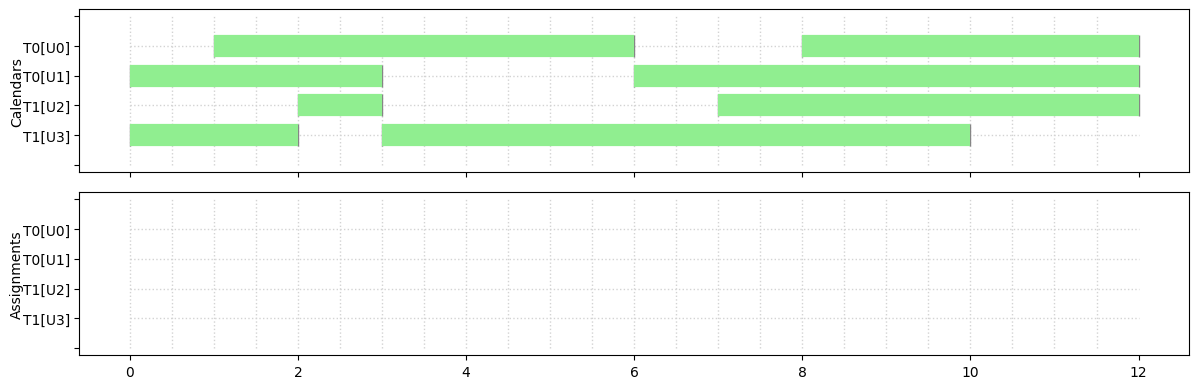

In [56]:
visualize_schedule(sol, RES_MAP, M, TYPES, Mode_Intervals=Mode_Intervals, origin=0, horizon=12)

## 2. Preemptive (No Delays) | Migration

$$
\begin{aligned}
\min \quad
& \max_{i \in \mathcal{N}} (\operatorname{end}(T_i))
& & \text{ (1)} \\[2mm]
\text{s.t.} \quad
& \operatorname{endBeforeStart}(T_i, T_j),
& \forall (i, j) \in \mathcal{E}
& \text{ (2)} \\[2mm]
& \sum_{i \in \mathcal{N}} \operatorname{pulse}(T_i, q_{i,k}) \leq A_k,
& \forall k \in \mathcal{K}
& \text{ (3)} \\[2mm]
& A_k(t) = \sum_{r \in \mathcal{U}_k} \mathcal{F}_r(t),
& \forall k \in \mathcal{K}
& \text{ (4)} \\[2mm]
& T_i: \text{mandatory interval var with size } d_i
& \forall i \in \mathcal{N}
& \text{ (5)}
\end{aligned}
$$

Objective
- **(1)** Minimize Makespan: Minimize the project completion time (the maximum end time across all tasks).

Modeling Constraints
- **(2)** Precedence Relations: Standard finish-to-start dependencies between tasks.
- **(3)** Aggregated Resource Capacity: At every time point $t$, the sum of resource demands from all active tasks must not exceed the available capacity $A_k(t)$. The `pulse` function contributes $q_{i,k}$ to the cumulative function during the execution of task $T_i$.
- **(4)** Available Capacity Function: The available capacity $A_k(t)$ for resource type $k$ at time $t$ is computed as the sum of individual unit availability step functions. 

Variable Definitions
- **(5)** $T_i$: Mandatory interval variable representing task $i$ with fixed processing duration $d_i$.

Sets & Parameters
- $\mathcal{N}$: Set of tasks to be scheduled
- $\mathcal{E}$: Set of precedence relations (finish-to-start dependencies)
- $\mathcal{K}$: Set of resource types (e.g., Electricians, Plumbers)
- $\mathcal{U}_k$: Set of resource units belonging to type $k$
- $q_{i,k}$: Quantity of resource type $k$ required by task $i$
- $d_i$: Processing duration of task $i$
- $\mathcal{F}_r(t) \in \{0, 1\}$: Availability calendar (step function) for resource unit $r$ at time $t$
- $A_k(t)$: The available capacity for resource type $k$ at time $t$

### IBM CPO DOcplex Implementation

#### Prepare Data

In [57]:
r_types = prepare_resource_types(TYPES)
r_breaks = extract_resource_breaks(UNITS)

#### Create model and variables

In [58]:
mdl = CpoModel(name="preemptive_nodelays_migration")

# (4) A_k(t): time-varying availability per resource type
A = {type_id: step_at(0, rtype["capacity"]) - sum(
    pulse((s, s+d), 1) for u in rtype["units"] if u in r_breaks for s, d in r_breaks[u])
    for type_id, rtype in r_types.items()}

# (5) T_i: mandatory interval var with size d_i
T = {tid: interval_var(size=size, name=f"T{tid}") for tid, size, _ in TASKS}

#### Add constraints and define objective

In [59]:
# (1) Objective: Minimize Makespan
mdl.add(minimize(mdl.max([end_of(T[i]) for i in range(N)])))

# (2) Precedences
mdl.add([end_before_start(T[p], T[s]) for p, s in PRECEDENCES])

# (3) aggregated resource capacity constraint
for type_id in r_types:
    usage = sum(pulse(T[tid], qty) for tid, _, reqs in TASKS 
                for req_type_id, qty in reqs if req_type_id == type_id and qty > 0)
    mdl.add(A[type_id] - usage >= 0)

#### Solve the model

In [60]:
print("Solving Preemptive (No Delays) | Migration...")
if sol := mdl.solve(LogVerbosity='Quiet'):
    sep = '='*75
    print(f"\n{sep}\n✓ SOLUTION - Makespan: {sol.get_objective_values()[0]}\n{sep}")
    print(f"{'Task':<5} {'Start':<5} {'End':<5} {'Dur':<5}\n{'-'*75}")
    for task_id in sorted(T.keys()):
        itv = sol.get_var_solution(T[task_id])
        print(f"T{task_id:<4} {itv.get_start():<5} {itv.get_end():<5} {itv.get_size():<5}")
    print(f"{sep}\n")
else:
    print("No solution found.")

Solving Preemptive (No Delays) | Migration...

✓ SOLUTION - Makespan: 10
Task  Start End   Dur  
---------------------------------------------------------------------------
T0    0     0     0    
T1    0     5     5    
T2    7     10    3    
T3    10    10    0    



#### Resource Unit Assignment (Post-Processing)

The aggregate `pulse` model above determines when tasks execute but not which specific units are assigned. Since tasks can migrate freely between available units, we compute a valid assignment greedily.

In [61]:
task_assignments = assign_resources_greedy(sol, T, TASKS, TYPE_MAP, RES_MAP)

In [62]:
print("Resource Unit Assignments:")
for tid in sorted(task_assignments):
    segs = task_assignments[tid]
    parts = ', '.join(f"{{{','.join(f'U{r}' for r in res)}}}@[{s}-{e})" for s, e, res in segs)
    print(f"  T{tid}: {parts or '—'}")

Resource Unit Assignments:
  T0: —
  T1: {U1,U3}@[0-2), {U0,U2}@[2-3), {U0,U3}@[3-5)
  T2: {U1,U2}@[7-10)
  T3: —


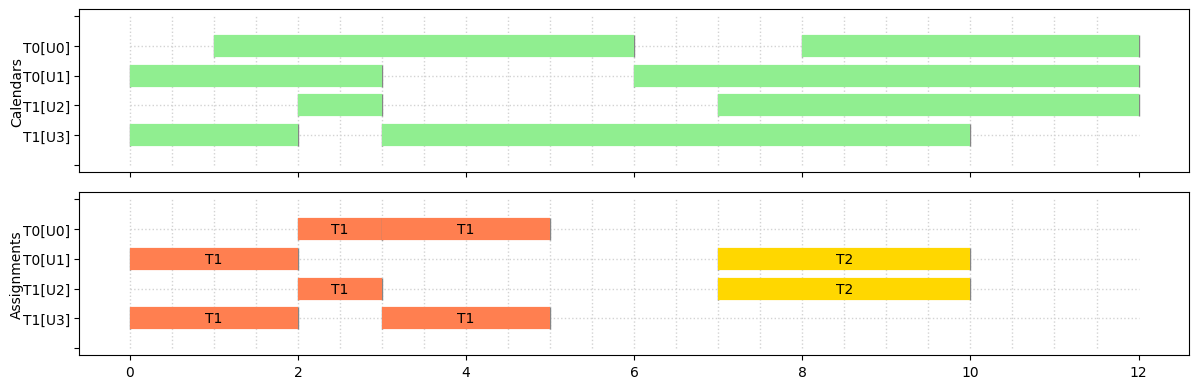

In [63]:
visualize_schedule(sol, RES_MAP, M, TYPES, assignments=task_assignments, origin=0, horizon=12)

## 3. Preemptive (With Delays) | No Migration

### Problem Definiton

We consider a project scheduling problem with a set of tasks $\mathcal{N}$ having fixed processing durations and subject to finish-to-start precedence relations $\mathcal{E}$.
Each task $i$ defines its requirements in terms of specific quantities of various resource types. For example, a task might require "2 Electricians and 1 Plumber". To fulfill these requirements, the task must be assigned to exactly one feasible team composition, known as a mode ($m \in \mathcal{M}_i$). Each mode $m$ specifies a concrete set of resource units $\mathcal{R}_{i,m}$ that satisfy the task's resource type requirements. Continuing the example, a specific mode might assign the resource unit "John" (who belongs to resource type "Electrician"), the resource unit "Mary" (who also belongs to resource type "Electrician"), and the resource unit "Steve" (who belongs to resource type "Plumber"). Each resource unit $r$ operates according to its own availability calendar $\mathcal{F}_r(t) \in \{0, 1\}$. The key challenge is synchronous blocking with calendar-based preemption. When a task requires multiple resource units, all assigned units must be available simultaneously. If resource unit John has a calendar-based day off, the task progress pauses, and resource units Mary and Steve remain blocked and unavailable to other tasks, even if their own calendars show they are available. Furthermore, resource capacity constraints ensure each unit can be assigned to at most one task at any time.

### CP Formulation

$$
\begin{aligned}
\min \quad
& \max_{i \in \mathcal{N}} (\operatorname{end}(T_i))
\qquad &\qquad & \text{(1)} \\[2mm]
\text{s.t.} \quad
& \operatorname{endBeforeStart}(T_i, T_j),
\qquad & \forall (i, j) \in \mathcal{E}
\quad & \text{(2)} \\[2mm]
& \operatorname{alternative}(T_i, \{O_{i,m} \mid m \in \mathcal{M}_i\}),
\qquad & \forall i \in \mathcal{N}
\quad & \text{(3)} \\[2mm]
& \operatorname{noOverlap}(\{O_{i,m} \mid i \in \mathcal{N}, m \in \mathcal{M}_i, r \in \mathcal{R}_{i,m}\}),
\qquad & \forall r \in \mathcal{R}
\quad & \text{(4)} \\[2mm]
& \operatorname{sizeOf}(O_{i,m}) = \int_{\operatorname{start}(O_{i,m})}^{\operatorname{end}(O_{i,m})} \mathcal{G}_{i,m}(t) \, dt,
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(5)} \\[2mm]
& \operatorname{forbidStart}(O_{i,m}, \mathcal{G}_{i,m}),
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(6)} \\[2mm]
& \mathcal{G}_{i,m}(t) = \min_{r \in \mathcal{R}_{i,m}} (\mathcal{F}_r(t)),
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(7)} \\[2mm]
& T_i: \text{mandatory interval var},
\qquad & \forall i \in \mathcal{N}
\quad & \text{(8a)} \\[1mm]
& O_{i,m}: \text{optional interval var}, \text{ intensity } \mathcal{G}_{i,m},
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(8b)}
\end{aligned}
$$

Objective
* **(1)** Minimize Makespan: Minimize the project completion time (the end time of the last task).

Modeling Constraints
* **(2)** Precedence Relations: Standard finish-to-start dependencies between tasks.
* **(3)** Mode Selection & Synchronization: The alternative constraint forces the solver to select exactly one valid combination of resource units (Mode $m$) for task $i$. It strictly synchronizes the Master Task $T_i$ with the selected Mode Interval $O_{i,m}$.
* **(4)** Resource Capacity: Ensures that an individual resource unit $r$ is processing by at most one task at a time. This constraint iterates over all potential modes $m$ across all tasks that contain the specific resource unit $r$.
* **(5)** Calendar-Based Blocking: The size (work content) of the mode interval is determined by the joint intensity $\mathcal{G}_{i,m}$. If the joint intensity is 0 (meaning any assigned resource unit, e.g., John, is on a break), the integral pauses the accumulation of size, forcing the interval duration to elongate. Because the resource units remain strictly assigned to this interval, Mary and Steve remain "Blocked" (unavailable to other tasks) during John's break.
* **(6)** Forbid Start During Unavailability: Prevents a task from starting at any time $t$ where $\mathcal{G}_{i,m}(t) = 0$. This eliminates idle time at the beginning of a task—ensuring productive work begins immediately when the task starts.

Note: Constraint (6) does not influence the makespan but ensures solution consistency—tasks must start only when all assigned resources are available, eliminating idle filler at the beginning of intervals.

Variable and Function Definitions
* **(7)** $\mathcal{G}_{i,m}(t)$: The joint intensity function. It represents the intersection of availability calendars. It is $100\%$ only if all resource units in mode $m$ are available at time $t$. If even one resource unit is unavailable, the value drops to 0.
* **(8a)** $T_i$: The Master interval variable representing the task execution window.
* **(8b)** $O_{i,m}$: An optional interval variable representing a specific assignment of resource units (Mode). Its intensity is linked to $\mathcal{G}_{i,m}$.

Parameters (Input Data)
* $\mathcal{N}$: The set of tasks.
* $\mathcal{M}_i$: The set of valid Modes for task $i$. These are pre-calculated combinations of resource units that satisfy the quantity requirements defined by the resource types.
* $\mathcal{R}_{i,m}$: The specific set of resource unit IDs belonging to mode $m$ of task $i$.
* $\mathcal{F}_r(t)$: The individual availability step function for the specific resource unit $r$.

### IBM CPO DOcplex Implementation

#### Prepare Data

In [64]:
Task_Modes = build_task_modes(TASKS, TYPE_MAP)

#### Create model and variables

In [65]:
mdl = CpoModel(name="preemptive_delays_nomigration_cpo")

In [66]:
# (7) G_{i,m}(t) = min(F_r(t)) - Joint intensity functions
Joint_Intensities = {
    (tid, mode): compute_joint_intensity(mode, RES_MAP)
    for tid in Task_Modes for mode in Task_Modes[tid]
}

# (5) + (8b) O_{i,m}: optional interval var with intensity G_{i,m}
Mode_Intervals = {
    (tid, mode): interval_var(size=size, intensity=Joint_Intensities[(tid, mode)],
                              optional=True, name=f"T{tid}_Mode_{mode}")
    for tid, size, _ in TASKS for mode in Task_Modes[tid]
}

# (8a) T_i: mandatory interval var
T = {tid: interval_var(name=f"T{tid}") for tid, _, _ in TASKS}

#### Add constraints and define objective

In [67]:
# (1) Objective: minimize makespan
mdl.add(minimize(mdl.max([end_of(T[i]) for i in range(N)])))

# (2) Precedences: endBeforeStart(T_i, T_j)
mdl.add([end_before_start(T[p], T[s]) for p, s in PRECEDENCES])

# (3) Alternative: mode selection & synchronization
for task_id in T:
    if modes := [itv for (t, m), itv in Mode_Intervals.items() if t == task_id]:
        mdl.add(alternative(T[task_id], modes))

# (4) Resource capacity: noOverlap per resource
for r in range(M):
    if intervals := [itv for (t, m), itv in Mode_Intervals.items() if r in m]:
        mdl.add(no_overlap(intervals))

# (6) Forbid start during unavailability
for (tid, mode), itv in Mode_Intervals.items():
    mdl.add(forbid_start(itv, Joint_Intensities[(tid, mode)]))

#### Solve the model

In [68]:
print("Solving...")
if sol := mdl.solve(LogVerbosity='Quiet'):
    print_solution(sol, T, Mode_Intervals, N)

Solving...


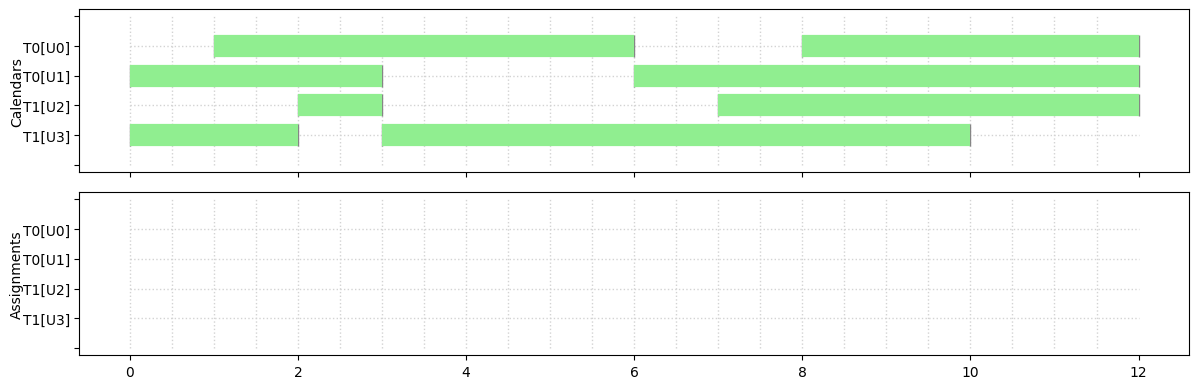

In [69]:
visualize_schedule(sol, RES_MAP, M, TYPES, Mode_Intervals=Mode_Intervals, origin=0, horizon=12)

## 4. Preemptive (With Delays) | Migration

Tasks can be interrupted (preempted) when insufficient aggregate resource capacity is available. The "Migration" policy means tasks are not locked to specific resource units — they can freely use any available units of the required type. When aggregate capacity drops below requirements, the task pauses; when capacity returns, it resumes (potentially on different units).

### CP Formulation

$$
\begin{aligned}
\min \quad
& \max_{i \in \mathcal{N}} (\operatorname{end}(T_i))
& & \text{ (1)} \\[2mm]
\text{s.t.} \quad
& \operatorname{endBeforeStart}(T_i, T_j),
& \forall (i, j) \in \mathcal{E}
& \text{ (2)} \\[2mm]
& \operatorname{span}(T_i, \{S_{i,w} \mid w \in \mathcal{W}_i\}),
& \forall i \in \mathcal{N}
& \text{ (3)} \\[2mm]
& \sum_{w \in \mathcal{W}_i} \operatorname{sizeOf}(S_{i,w}) = d_i,
& \forall i \in \mathcal{N}
& \text{ (4)} \\[2mm]
& S_{i,w} \subseteq [w^s, w^e),
& \forall i \in \mathcal{N}, \forall w \in \mathcal{W}_i
& \text{ (5)} \\[2mm]
& \sum_{i \in \mathcal{N}} \sum_{w \in \mathcal{W}_i} \operatorname{pulse}(S_{i,w}, q_{i,k}) \leq A_k,
& \forall k \in \mathcal{K}
& \text{ (6)} \\[2mm]
& A_k(t) = \sum_{r \in \mathcal{U}_k} \mathcal{F}_r(t),
& \forall k \in \mathcal{K}
& \text{ (7)} \\[2mm]
& \mathcal{W}_i = \{[w^s, w^e) \mid A_k(t) \geq q_{i,k}, \forall k \in \mathcal{K}_i, \forall t \in [w^s, w^e)\},
& \forall i \in \mathcal{N}
& \text{ (8)} \\[2mm]
& T_i: \text{mandatory interval var}
& \forall i \in \mathcal{N}
& \text{ (9a)} \\[1mm]
& S_{i,w}: \text{optional interval var}
& \forall i \in \mathcal{N}, \forall w \in \mathcal{W}_i
& \text{ (9b)}
\end{aligned}
$$

**Sets & Parameters**
- $\mathcal{N}$: Set of tasks
- $\mathcal{E}$: Precedence relations (finish-to-start)
- $\mathcal{K}$: Resource types
- $\mathcal{K}_i \subseteq \mathcal{K}$: Resource types required by task $i$
- $\mathcal{U}_k$: Resource units belonging to type $k$
- $q_{i,k}$: Quantity of type $k$ required by task $i$
- $d_i$: Processing duration (work content) of task $i$
- $\mathcal{F}_r(t) \in \{0, 1\}$: Availability calendar for unit $r$
- $\mathcal{W}_i$: Capacity windows for task $i$ — maximal time intervals where aggregate capacity satisfies all requirements

**Objective**
- **(1)** Minimize Makespan: Minimize project completion time.

**Modeling Constraints**
- **(2)** Precedence Relations: Standard finish-to-start dependencies.
- **(3)** Span Constraint: Master interval $T_i$ spans all its active segments.
- **(4)** Work Content: Total work across all segments equals required duration $d_i$.
- **(5)** Window Containment: Each segment must stay within its capacity window.
- **(6)** Aggregated Capacity: Prevents over-allocation — pulses are generated by segments, not master intervals.
- **(7)** Capacity Function: $A_k(t)$ is the sum of individual unit availabilities.
- **(8)** Capacity Windows: Pre-computed intervals where aggregate capacity meets task requirements.

**Variable Definitions**
- **(9a)** $T_i$: Master interval representing task $i$'s execution span.
- **(9b)** $S_{i,w}$: Optional segment interval for task $i$ within capacity window $w$.

### IBM CPO DOcplex Implementation

#### Prepare Data

In [70]:
r_types = prepare_resource_types(TYPES)
r_breaks = extract_resource_breaks(UNITS)

for tid, size, reqs in TASKS:
    print(f"T{tid} (needs {reqs}): {compute_capacity_windows(reqs, TYPE_MAP, RES_MAP)}")

T0 (needs [(0, 0), (1, 0)]): [(0, 100000)]
T1 (needs [(0, 1), (1, 1)]): [(0, 12)]
T2 (needs [(0, 1), (1, 2)]): [(7, 10)]
T3 (needs [(0, 0), (1, 0)]): [(0, 100000)]


#### Create model and variables

In [71]:
mdl = CpoModel(name="preemptive_withdelays_migration_segments")

# (8)
Task_Windows = {tid: compute_capacity_windows(reqs, TYPE_MAP, RES_MAP) 
                for tid, size, reqs in TASKS}

# (9a)
T = {tid: interval_var(name=f"T{tid}") for tid, size, _ in TASKS}

# (9b)
Segments = {(tid, i): interval_var(optional=True, start=(s, e-1), end=(s+1, e), name=f"T{tid}_seg{i}")
            for tid in Task_Windows for i, (s, e) in enumerate(Task_Windows[tid])}

#### Add constraints and define objective

In [72]:
# (1) Objective: minimize makespan
mdl.add(minimize(max(end_of(T[tid]) for tid in T)))

# (2) Precedences
mdl.add([end_before_start(T[p], T[s]) for p, s in PRECEDENCES])

# (3) Span constraint: master interval spans all its segments
for tid, size, reqs in TASKS:
    segs = [Segments[(tid, w)] for w in range(len(Task_Windows[tid]))]
    if segs:
        mdl.add(span(T[tid], segs))

# (4) Work content: sum of segment sizes = required duration
for tid, size, reqs in TASKS:
    if size > 0:
        segs = [Segments[(tid, w)] for w in range(len(Task_Windows[tid]))]
        mdl.add(sum(size_of(s, 0) for s in segs) == size)

# (5) Segments within capacity windows
for (tid, w), seg in Segments.items():
    s, e = Task_Windows[tid][w]
    mdl.add([if_then(presence_of(seg), start_of(seg) >= s), 
             if_then(presence_of(seg), end_of(seg) <= e)])

# (6) Cumulative capacity using segments
A = {type_id: step_at(0, rt["capacity"]) - sum(pulse((s, s+d), 1) 
     for u in rt["units"] if u in r_breaks for s, d in r_breaks[u])
     for type_id, rt in r_types.items()}

for type_id in r_types:
    usage = [pulse(Segments[(tid, w)], qty) for tid, _, reqs in TASKS 
             for req_type_id, qty in reqs 
             if qty > 0 and req_type_id == type_id 
             for w in range(len(Task_Windows[tid]))]
    if usage:
        mdl.add(A[type_id] - sum(usage) >= 0)

#### Solve the model

In [73]:
print("Solving Preemptive (With Delays) | Migration (Segment Model)...")
sol = mdl.solve(LogVerbosity='Quiet')

Solving Preemptive (With Delays) | Migration (Segment Model)...


In [74]:
if sol:
    sep = '='*75
    print(f"\n{sep}\n✓ SOLUTION - Makespan: {sol.get_objective_values()[0]}\n{sep}\n{'Task':<5} {'Start':<5} {'End':<5} {'Size':<5} {'Segments'}\n{'-'*75}")
    for tid in sorted(T):
        t = sol.get_var_solution(T[tid])
        segs = [s for s in (sol.get_var_solution(Segments[(tid, w)]) 
                for w in range(len(Task_Windows[tid]))) if s and s.is_present()]
        print(f"T{tid:<4} {t.get_start():<5} {t.get_end():<5} {sum(s.get_size() for s in segs):<5} {', '.join(f'[{s.get_start()}-{s.get_end()})' for s in segs) or '—'}")
    print(f"{sep}\n")
else:
    print("No solution found.")


✓ SOLUTION - Makespan: 10
Task  Start End   Size  Segments
---------------------------------------------------------------------------
T0    0     1     1     [0-1)
T1    1     6     5     [1-6)
T2    7     10    3     [7-10)
T3    10    10    0     [10-10)



#### Resource Unit Assignment (Post-Processing)

In [75]:
task_assignments = extract_segment_assignments(
    sol, Segments, Task_Windows, TASKS, TYPE_MAP, RES_MAP)

print("Resource Unit Assignments (with delays and migration):")
for tid in sorted(task_assignments):
    print(f"  T{tid}: {', '.join(f'{{{','.join(f'U{r}' for r in res)}}}@[{s}-{e})' for s, e, res in task_assignments[tid]) or '—'}")

Resource Unit Assignments (with delays and migration):
  T0: —
  T1: {U0,U1}@[1-2), {U0,U1}@[2-3), {U0,U3}@[3-6)
  T2: {U1,U2,U3}@[7-8), {U0,U1,U2}@[8-10)
  T3: —


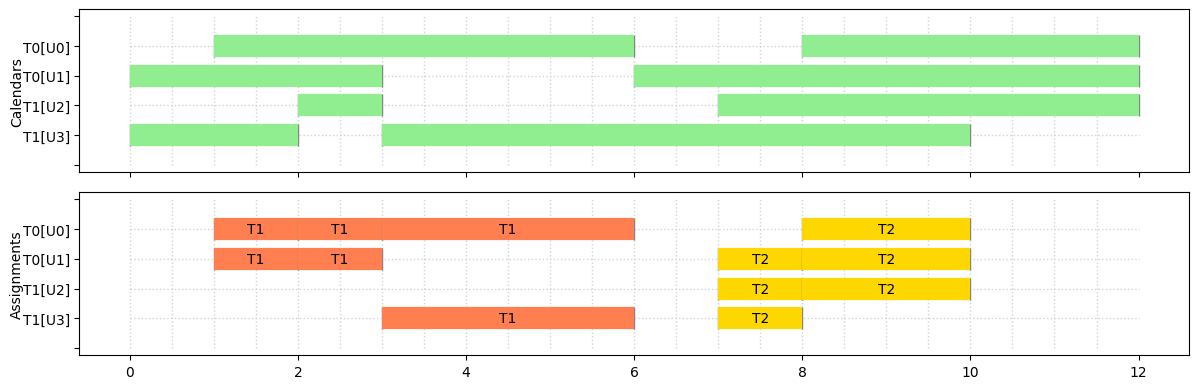

In [76]:
visualize_schedule(sol, RES_MAP, M, TYPES, assignments=task_assignments, origin=0, horizon=12)

## 5. Multi-Resource Heterogeneous Policy

This problem models scenarios where different resource types follow different scheduling policies within the same project. Machines follow a Non-Preemptive | No Migration policy: once a task is assigned to a specific machine, it must execute continuously on that same machine without interruption, and the task must fit entirely within the machine's availability window. Workers follow a Preemptive (No Delays) | Migration policy: tasks can freely switch between available workers during execution, and as long as enough workers are available in aggregate, the task continues without pause. 

$$
\begin{aligned}
\min \quad
& \max_{i \in \mathcal{N}} (\operatorname{end}(T_i))
& & \text{ (1)} \\[2mm]
\text{s.t.} \quad
& \operatorname{endBeforeStart}(T_i, T_j),
& \forall (i, j) \in \mathcal{E}
& \text{ (2)} \\[2mm]
& \operatorname{alternative}(T_i, \{O_{i,r} \mid r \in \mathcal{U}_k\}, q_{i,k}),
& \forall i \in \mathcal{N}, \forall k \in \mathcal{K}_i^{fix}
& \text{ (3)} \\[2mm]
& \operatorname{noOverlap}(\{O_{i,r} \mid i \in \mathcal{N}, r \in \mathcal{C}_i^{fix}\}),
& \forall r \in \bigcup_{k \in \mathcal{K}^{fix}} \mathcal{U}_k
& \text{ (4)} \\[2mm]
& \operatorname{forbidExtent}(O_{i,r}, \overline{\mathcal{F}_r}),
& \forall i \in \mathcal{N}, \forall r \in \mathcal{C}_i^{fix}
& \text{ (5)} \\[2mm]
& \sum_{i \in \mathcal{N}} \operatorname{pulse}(T_i, q_{i,k}) \leq A_k,
& \forall k \in \mathcal{K}^{mig}
& \text{ (6)} \\[2mm]
& A_k(t) = \sum_{r \in \mathcal{U}_k} \mathcal{F}_r(t),
& \forall k \in \mathcal{K}^{mig}
& \text{ (7)} \\[2mm]
& T_i: \text{mandatory interval var with size } d_i
& \forall i \in \mathcal{N}
& \text{ (8a)} \\[1mm]
& O_{i,r}: \text{optional interval var with size } d_i
& \forall i \in \mathcal{N}, \forall r \in \mathcal{C}_i^{fix}
& \text{ (8b)}
\end{aligned}
$$

**Sets & Parameters**
- $\mathcal{N}$: Set of tasks
- $\mathcal{E}$: Precedence relations (finish-to-start)
- $\mathcal{K}$: All resource types
- $\mathcal{K}^{fix} \subseteq \mathcal{K}$: Resource types requiring fixed assignment (no migration, e.g., machines)
- $\mathcal{K}^{mig} \subseteq \mathcal{K}$: Resource types allowing migration (e.g., workers)
- $\mathcal{K}_i^{fix} = \mathcal{K}_i \cap \mathcal{K}^{fix}$: Fixed-type requirements for task $i$
- $\mathcal{U}_k$: Resource units belonging to type $k$
- $\mathcal{C}_i^{fix} = \bigcup_{k \in \mathcal{K}_i^{fix}} \mathcal{U}_k$: All candidate units of fixed types for task $i$
- $q_{i,k}$: Quantity of type $k$ required by task $i$
- $d_i$: Processing duration of task $i$
- $\mathcal{F}_r(t) \in \{0, 1\}$: Availability calendar for unit $r$
- $\overline{\mathcal{F}_r}$: Complement of availability (unavailability periods)

**Objective**
- **(1)** Minimize Makespan: Minimize project completion time.

**Constraints for Fixed Types (No Migration)**
- **(3)** Unit Selection: For each fixed-type requirement, select exactly $q_{i,k}$ units via `alternative` with cardinality. Selected unit intervals synchronize with master interval $T_i$.
- **(4)** Unit Capacity: Each unit of a fixed type can execute at most one task at a time.
- **(5)** Calendar Compliance: Unit intervals must fall entirely within the unit's availability windows.

**Constraints for Migration Types**
- **(6)** Aggregated Capacity: At every time $t$, total demand for migration-type $k$ must not exceed available capacity $A_k(t)$.
- **(7)** Capacity Function: Available capacity is the sum of individual unit availabilities.

**Variable Definitions**
- **(8a)** $T_i$: Master interval with fixed size $d_i$.
- **(8b)** $O_{i,r}$: Optional interval for task $i$ on fixed-type unit $r$ with size $d_i$.

Fixed types use explicit unit assignment (alternative + noOverlap + forbidExtent), while migration types use aggregate capacity (pulse). This models scenarios like "task must stay on the same machine, but workers can rotate."

#### Load Instance

In [77]:
RES_MAP = dict(UNITS)
TYPE_MAP = dict(TYPES)
r_types = prepare_resource_types(TYPES)
r_breaks = extract_resource_breaks(UNITS)

# Define which types allow migration vs fixed assignment
# Example: Type 0 = Machines (no migration), Type 1 = Workers (migration)
FIXED_TYPES = {0}      # No migration - use alternative constraint
MIGRATION_TYPES = {1}  # Migration allowed - use pulse constraint

print_instance(N, K, M, TASKS, TYPES, UNITS, PRECEDENCES)
print(f"Fixed types (no migration): {FIXED_TYPES}")
print(f"Migration types: {MIGRATION_TYPES}")


INSTANCE: 4 Tasks × 2 Types × 4 Units

Resource Types:
  Type 0: Units {U0, U1}
  Type 1: Units {U2, U3}

Task   Dur  Requirements                   → Succ
---------------------------------------------------------------------------
T0     0    —                              [1, 2]
T1     5    1×Type0, 1×Type1               [3]
T2     3    1×Type0, 2×Type1               [3]
T3     0    —                              —

Unit   Type   Available Windows
---------------------------------------------------------------------------
U0     T0     [1-6) [8-12)
U1     T0     [0-3) [6-12)
U2     T1     [2-3) [7-12)
U3     T1     [0-2) [3-10)

Fixed types (no migration): {0}
Migration types: {1}


#### Create Model and Variables

In [78]:
mdl = CpoModel(name="heterogeneous_policy")

# Master intervals
T = {tid: interval_var(size=size, name=f"T{tid}") for tid, size, _ in TASKS}

# Unit intervals ONLY for fixed types
Unit_Intervals = {}
for task_id, size, reqs in TASKS:
    for type_id, qty in reqs:
        if type_id in FIXED_TYPES and qty > 0:
            for r in TYPE_MAP[type_id]:
                if (task_id, r) not in Unit_Intervals:
                    Unit_Intervals[(task_id, r)] = interval_var(
                        size=size, optional=True, name=f"T{task_id}_U{r}")

# Availability functions for fixed types
Res_Availability = {unit_id: create_availability_function(steps) 
                    for unit_id, steps in UNITS
                    if any(unit_id in TYPE_MAP[k] for k in FIXED_TYPES)}

# Capacity functions for migration types
A = {type_id: step_at(0, rtype["capacity"]) - sum(
        pulse((s, s+d), 1) for u in rtype["units"] if u in r_breaks for s, d in r_breaks[u])
     for type_id, rtype in r_types.items() if type_id in MIGRATION_TYPES}

#### Add Constraints and Define Objective

In [79]:
# (1) Objective: minimize makespan
mdl.add(minimize(max([end_of(T[tid]) for tid in T])))

# (2) Precedences
mdl.add([end_before_start(T[p], T[s]) for p, s in PRECEDENCES])

# (3) Alternative for FIXED types: select specific units
for task_id, size, reqs in TASKS:
    for type_id, qty in reqs:
        if type_id in FIXED_TYPES and qty > 0:
            candidates = TYPE_MAP[type_id]
            unit_intervals = [Unit_Intervals[(task_id, r)] for r in candidates]
            mdl.add(alternative(T[task_id], unit_intervals, cardinality=qty))

# (4) No overlap per unit for FIXED types
for type_id in FIXED_TYPES:
    for r in TYPE_MAP[type_id]:
        intervals = [itv for (tid, uid), itv in Unit_Intervals.items() if uid == r]
        if intervals:
            mdl.add(no_overlap(intervals))

# (5) Calendar compliance for FIXED types
for (task_id, r), itv in Unit_Intervals.items():
    if r in Res_Availability:
        mdl.add(forbid_extent(itv, Res_Availability[r]))

# (6) Aggregate capacity for MIGRATION types
for type_id in MIGRATION_TYPES:
    pulses = [pulse(T[tid], qty) for tid, _, reqs in TASKS 
              for req_type_id, qty in reqs if req_type_id == type_id and qty > 0]
    if pulses:  # Check Python list, not CPO expression
        mdl.add(A[type_id] - sum(pulses) >= 0)

#### Solve the model

In [80]:
print("Solving Heterogeneous Policy...")
sol = mdl.solve(LogVerbosity='Quiet')

Solving Heterogeneous Policy...


In [81]:
if sol:
    sep = '='*75
    print(f"\n{sep}\n✓ SOLUTION - Makespan: {sol.get_objective_values()[0]}\n{sep}")
    print(f"{'Task':<5} {'Start':<5} {'End':<5} {'Fixed Units':<20} {'Migration Types'}")
    print(f"{'-'*75}")
    
    for tid, size, reqs in TASKS:
        t_sol = sol.get_var_solution(T[tid])
        if t_sol:
            # Get fixed unit assignments
            fixed_units = [r for (t, r), itv in Unit_Intervals.items() 
                          if t == tid and (s := sol.get_var_solution(itv)) and s.is_present()]
            fixed_str = "{" + ",".join(f"U{r}" for r in sorted(fixed_units)) + "}" if fixed_units else "—"
            
            # Get migration type requirements
            mig_reqs = [(type_id, qty) for type_id, qty in reqs if type_id in MIGRATION_TYPES and qty > 0]
            mig_str = ", ".join(f"{qty}×T{type_id}" for type_id, qty in mig_reqs) if mig_reqs else "—"
            
            print(f"T{tid:<4} {t_sol.get_start():<5} {t_sol.get_end():<5} {fixed_str:<20} {mig_str}")
    print(f"{sep}\n")
else:
    print("No solution found.")


✓ SOLUTION - Makespan: 10
Task  Start End   Fixed Units          Migration Types
---------------------------------------------------------------------------
T0    0     0     —                    —
T1    1     6     {U0}                 1×T1
T2    7     10    {U1}                 2×T1
T3    10    10    —                    —



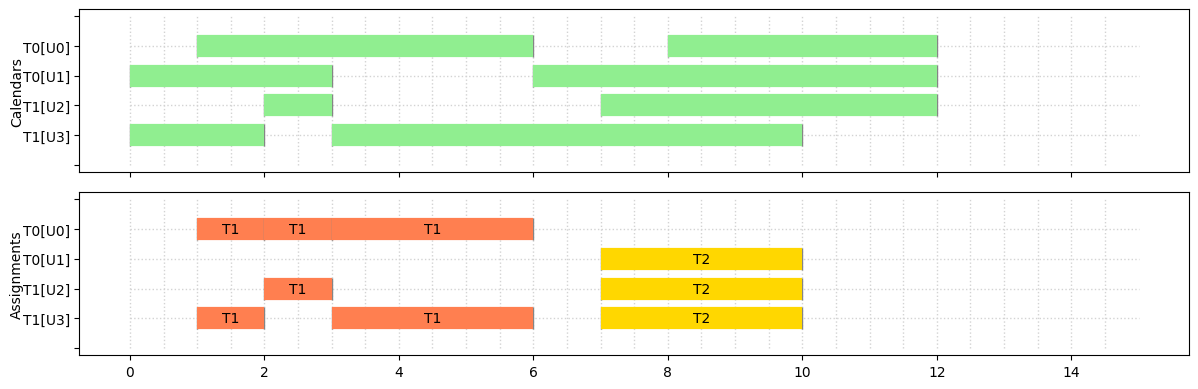

In [ ]:
def extract_heterogeneous_assignments(sol, T, TASKS, TYPE_MAP, RES_MAP, 
                                      Unit_Intervals, FIXED_TYPES, MIGRATION_TYPES):
    """Extract all assignments (fixed + migration) into unified format."""
    AVAILABILITY = {r: [(t, steps[i+1][0] if i+1 < len(steps) else HORIZON)
                        for i, (t, v) in enumerate(steps) if v > 0]
                    for r, steps in RES_MAP.items()}
    
    assignments = {}
    used = {r: [] for r in RES_MAP}
    
    for tid, size, reqs in TASKS:
        t_sol = sol.get_var_solution(T[tid])
        if not t_sol:
            continue
        start, end = t_sol.get_start(), t_sol.get_end()
        
        if start == end:
            assignments[tid] = []
            continue
        
        # Get fixed-type units (from solver)
        fixed_units = [r for (t, r), itv in Unit_Intervals.items() 
                       if t == tid and (s := sol.get_var_solution(itv)) and s.is_present()]
        
        # Get migration-type requirements
        mig_reqs = [(type_id, qty) for type_id, qty in reqs 
                    if type_id in MIGRATION_TYPES and qty > 0]
        
        if not mig_reqs:
            # Only fixed types - single segment
            if fixed_units:
                assignments[tid] = [(start, end, tuple(sorted(fixed_units)))]
            else:
                assignments[tid] = []
        else:
            # Migration types need segmentation
            segments, t = [], start
            while t < end:
                selected = list(fixed_units)  # Always include fixed units
                for type_id, qty in mig_reqs:
                    count = 0
                    for r in TYPE_MAP[type_id]:
                        if (r not in selected 
                            and any(s <= t < e for s, e in AVAILABILITY.get(r, []))
                            and all(not (s <= t < e) for s, e in used[r])):
                            selected.append(r)
                            count += 1
                            if count >= qty:
                                break
                if len(selected) <= len(fixed_units):
                    break  # No migration units found
                seg_end = min(min(e for r in selected if r not in fixed_units 
                                  for s, e in AVAILABILITY[r] if s <= t < e), end)
                segments.append((t, seg_end, tuple(sorted(selected))))
                for r in selected:
                    if r not in fixed_units:
                        used[r].append((t, seg_end))
                t = seg_end
            assignments[tid] = segments
    
    return assignments

# Single call to extract everything
task_assignments = extract_heterogeneous_assignments(
    sol, T, TASKS, TYPE_MAP, RES_MAP, Unit_Intervals, FIXED_TYPES, MIGRATION_TYPES)

# Visualize
visualize_schedule(sol, RES_MAP, M, TYPES, assignments=task_assignments, origin=0, horizon=12)